Mounted at /content/drive
{1451.0: [1451]}


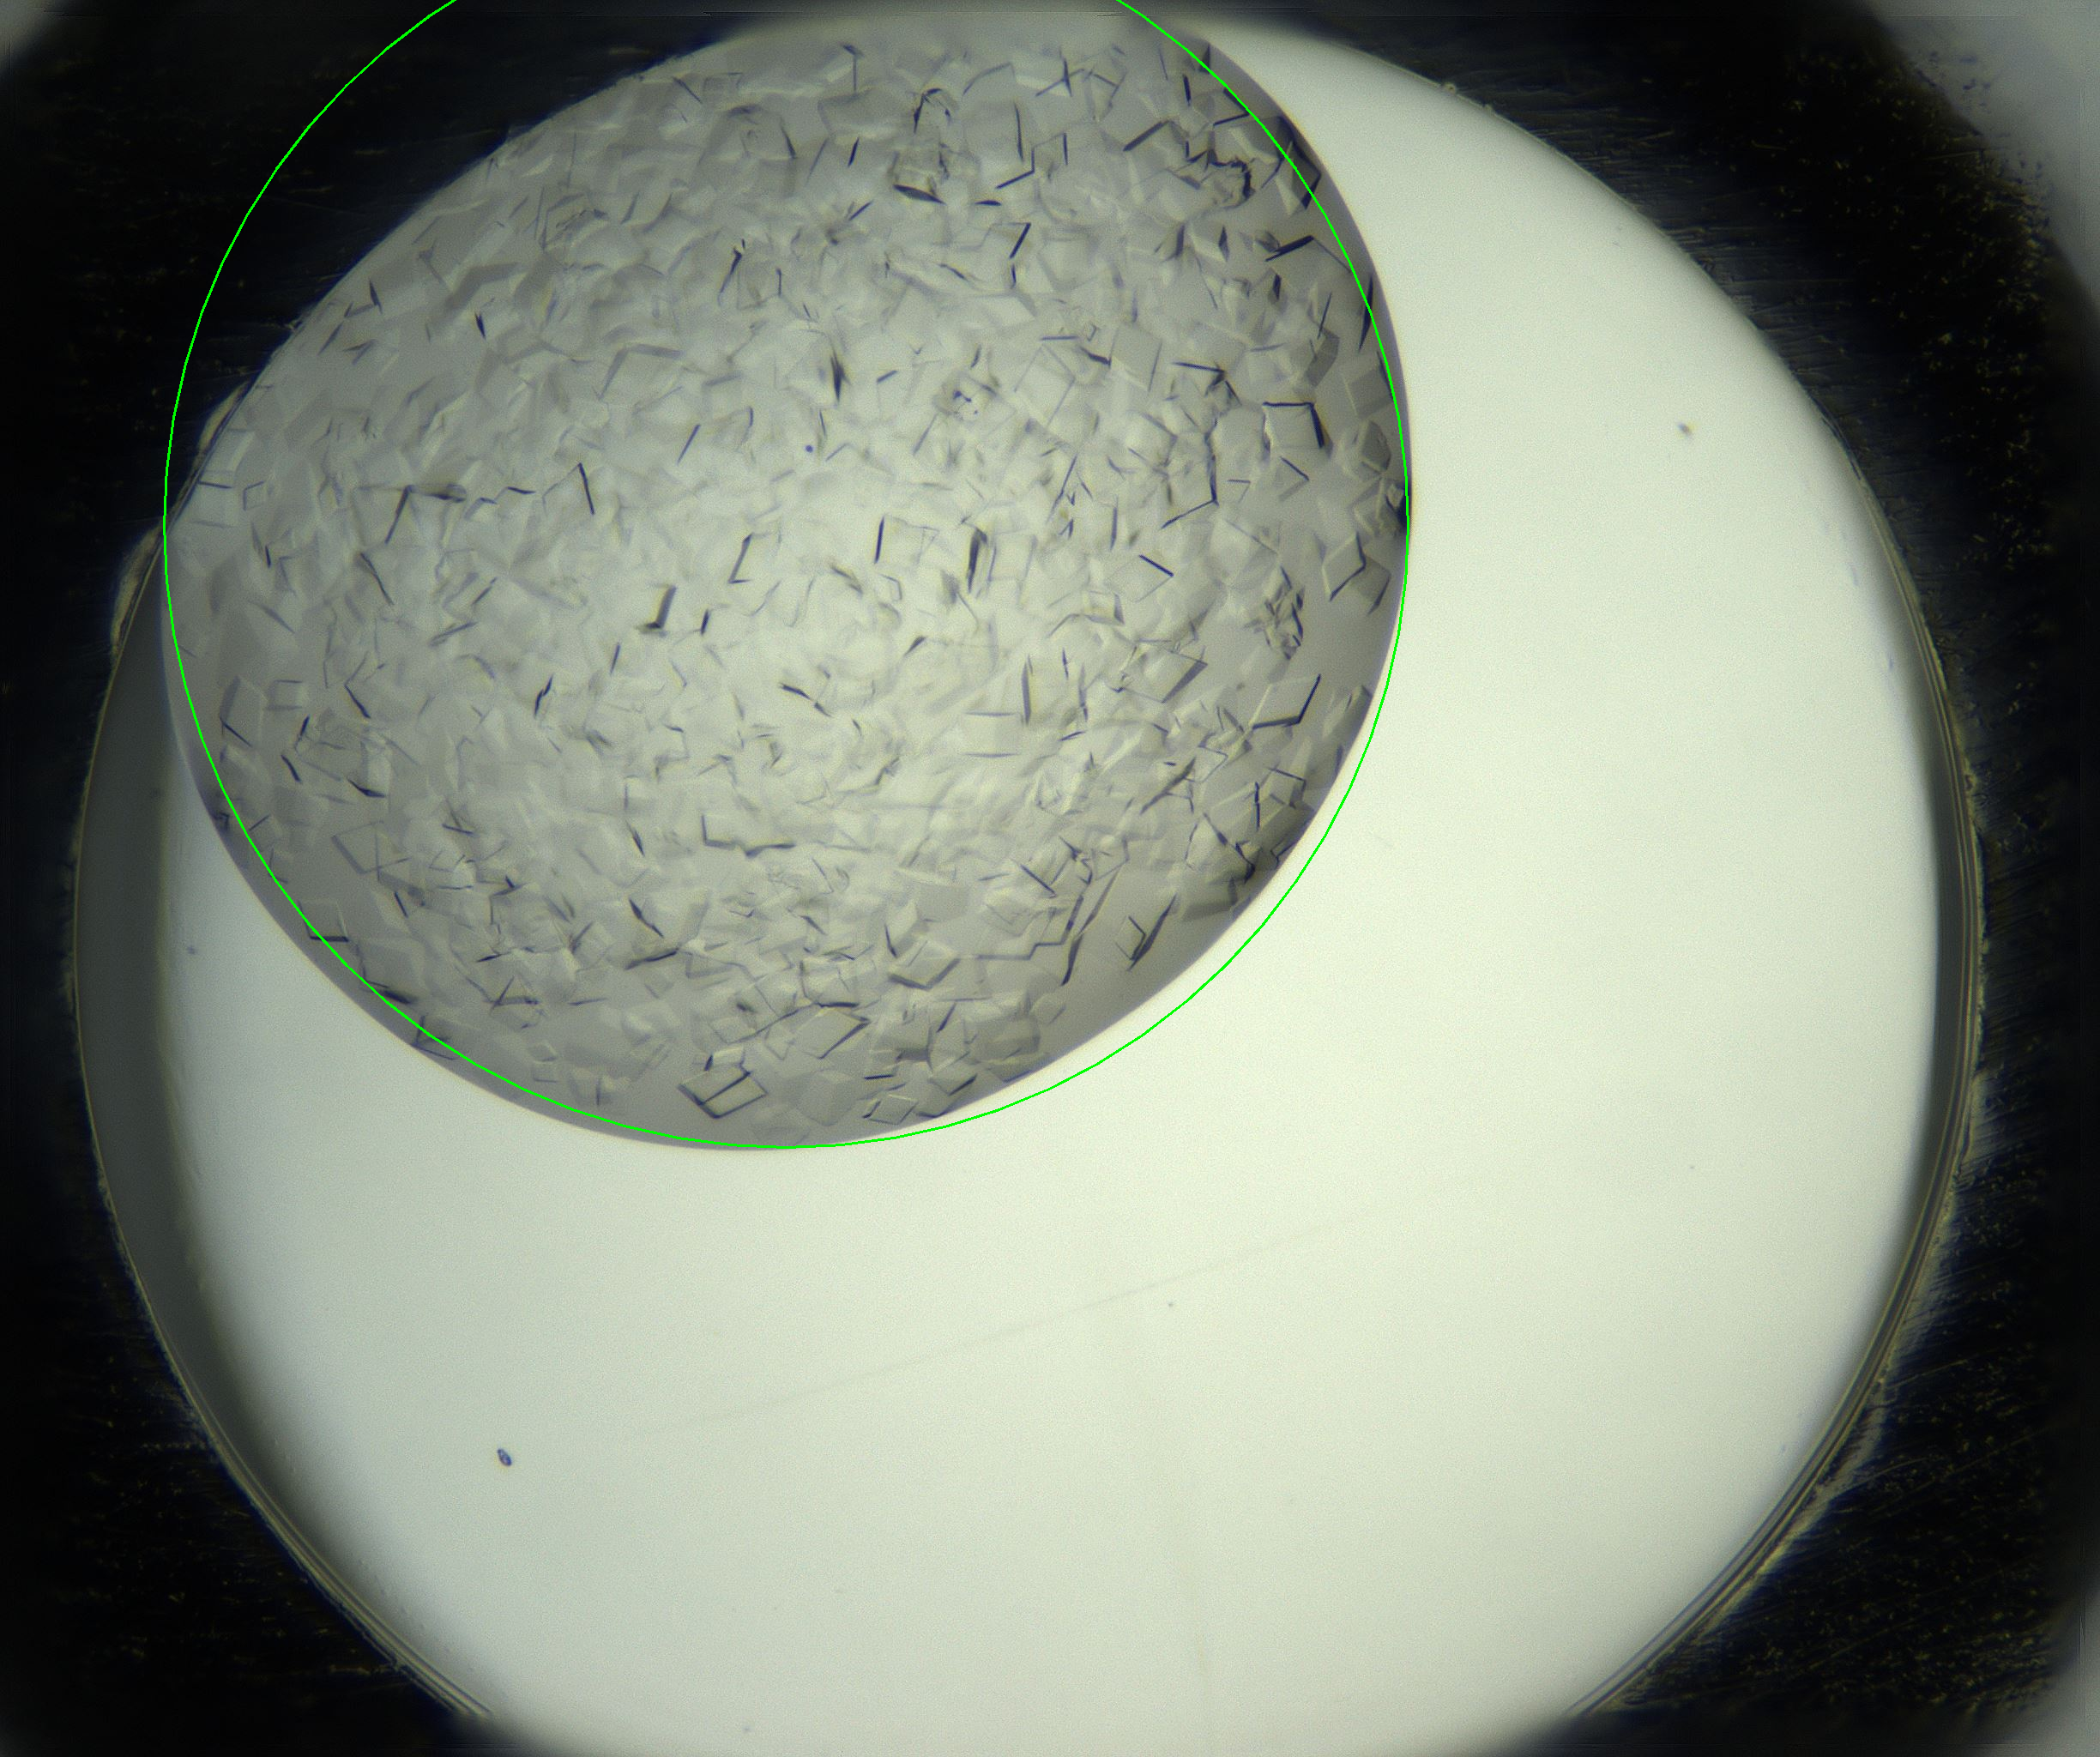

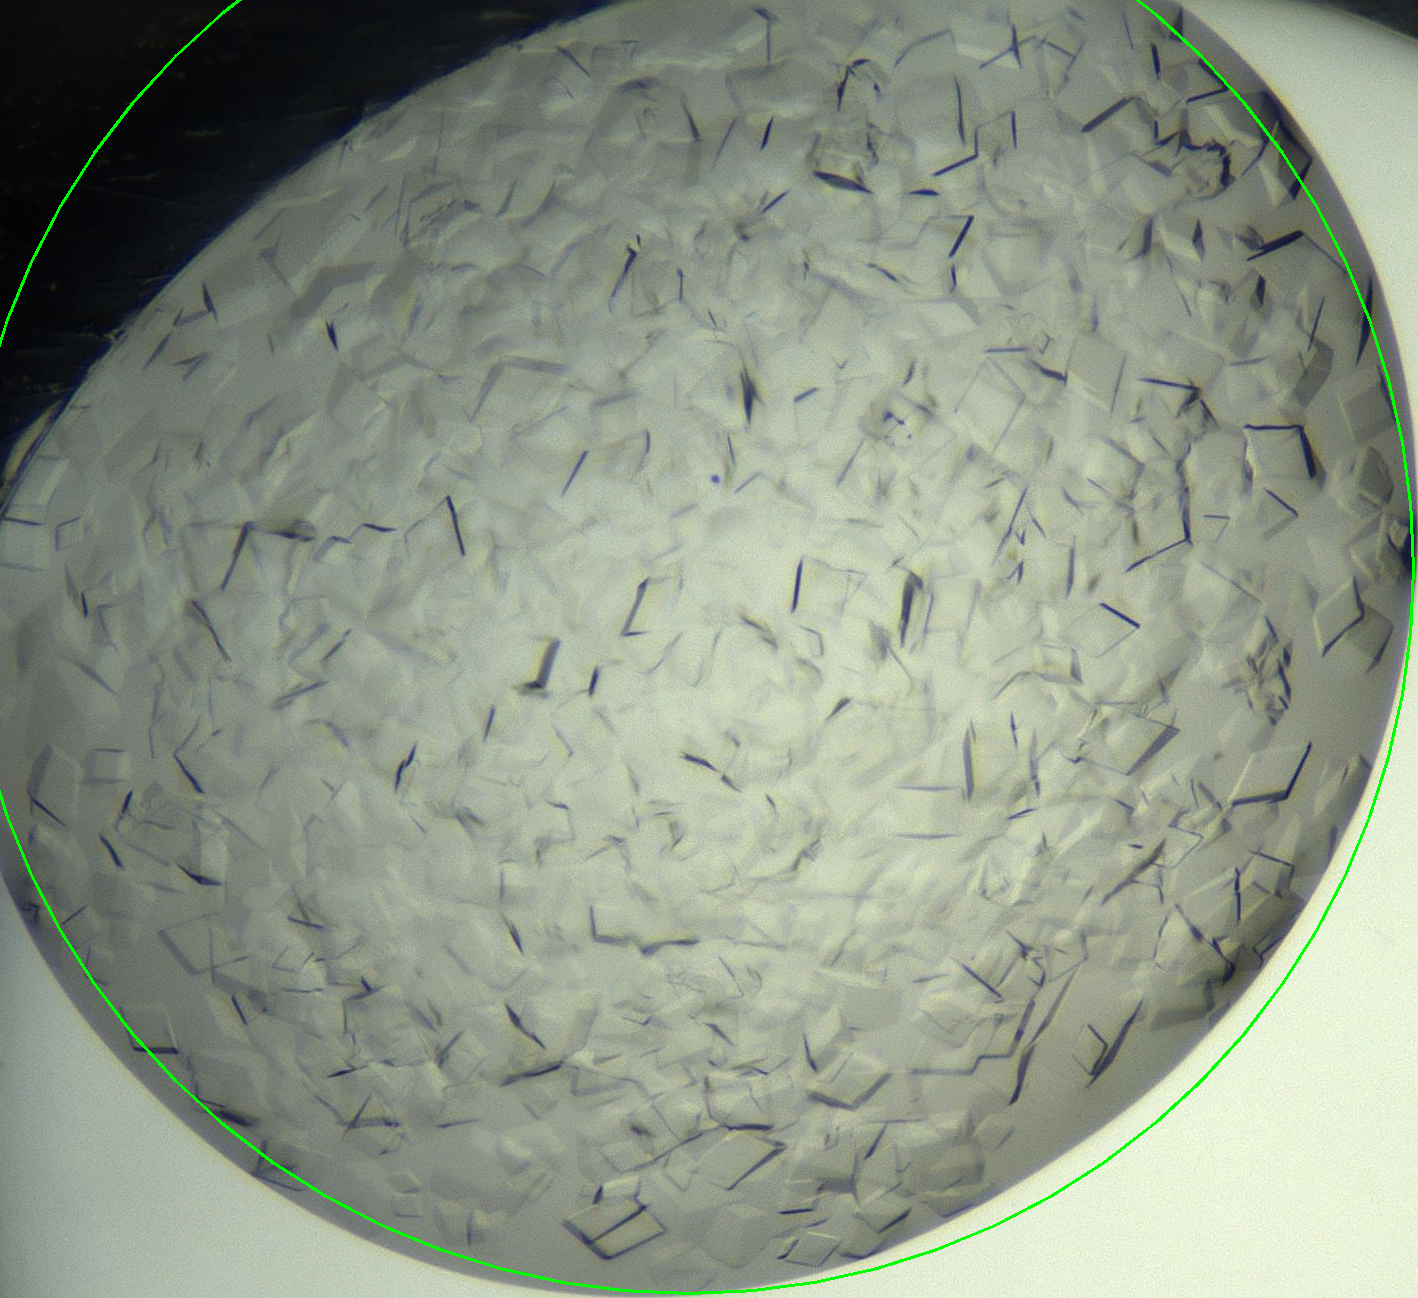

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab.patches import cv2_imshow

import cv2
import numpy as np

# Load the image
#image = cv2.imread('/content/drive/MyDrive/Capstone/ExcipientA_Images/ExcipientA_WellNum_53_Col_5.jpg')
#image = cv2.imread('/content/drive/MyDrive/Capstone/ExcipientA_Images/ExcipientA_WellNum_65_Col_5.jpg')
#image = cv2.imread('/content/drive/MyDrive/Capstone/ExcipientA_Images/ExcipientA_WellNum_77_Col_5.jpg')
image = cv2.imread('/content/drive/MyDrive/Capstone/ExcipientA_Images/ExcipientA_WellNum_89_Col_5.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
blurred = cv2.GaussianBlur(blurred, (5, 5), 0)
blurred = cv2.GaussianBlur(blurred, (5, 5), 0)

# Detect edges using Canny edge detection
edges = cv2.Canny(blurred, 50, 200)  # Adjust the thresholds here

# Find contours in the edged image
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


# Initialize a list to store circle information
circles_info = []
cropped_images = []
mask = np.zeros_like(image)

# Iterate through detected contours
for contour in contours:
    # Fit an ellipse to the contour (assuming it's a circle)
    if len(contour) >= 5:
        ellipse = cv2.fitEllipse(contour)

        # Extract ellipse information: center, axes lengths (major and minor), and angle
        center, axes, angle = ellipse

        # Calculate the diameter of the circle (average of major and minor axes)
        diameter = int((axes[0] + axes[1]) / 2.0)

        #Filter out diameter size
        if diameter > 1000:
          # Filter out non-circular shapes based on aspect ratio
          min_axis_length = min(axes)
          if min_axis_length > 0:
              aspect_ratio = max(axes) / min_axis_length
              if aspect_ratio < 1.2:
                  # Store circle information as a tuple (center, diameter)
                  circles_info.append((center, diameter))

                  # Crop the image using the contour
                  x, y, w, h = cv2.boundingRect(contour)
                  cropped_image = image[y:y+h, x:x+w]
                  cropped_images.append(cropped_image)


# Calculate the average diameter for each circle
average_diameters = {}

# Iterate through detected circles and calculate the average diameter
for _, diameter in circles_info:
    # Find circles with similar diameters
    similar_diameters = [d for _, d in circles_info if abs(d - diameter) < 10]

    # Calculate the average diameter
    average_diameter = sum(similar_diameters) / len(similar_diameters)

    # Store the average diameter with the diameter value as the key
    average_diameters[average_diameter] = similar_diameters
    print(average_diameters)

# Draw the circles and their average diameters on the original image
for center, diameter in circles_info:
    # Convert the center coordinates to integers
    center = (int(center[0]), int(center[1]))

    # Draw the circle
    cv2.circle(image, center, int(diameter / 2), (0, 255, 0), 2)

    # Calculate the topmost point on the circle
    topmost_point = center[1] - int(diameter / 2)

    # Find the corresponding average diameter
    for avg_diameter, similar_diameters in average_diameters.items():
        if diameter in similar_diameters:
            # Draw the average diameter as text next to the circle
            cv2.putText(image, f"Diameter: {avg_diameter:.2f}", (center[0], topmost_point),
                        cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 2)
            break

# Display the image with circles and average diameters
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

for i, cropped_image in enumerate(cropped_images):
    cv2_imshow(cropped_image)
    cv2.waitKey(0)